In [1]:
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import shap
import warnings
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from utils import scale_data, inverse_transform, lineplot, scatterplot
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

In [57]:
df = pd.read_excel('Data/all_data.xlsx')

In [58]:
df.tail()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,65496611844,positif,92,61198.382813


# PREPROCESSING

In [59]:
df = df.drop(columns=['Date', 'Volume', 'Sentimen', 'Index'])

In [60]:
X = df.drop('Close', axis=1)
y = df['Close']

In [61]:
X, y, scaler = scale_data(df)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# MODELING

In [68]:
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=150))
model.add(Dense(25))
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=[X_test, y_test])

Train on 292 samples, validate on 73 samples
Epoch 1/20
292/292 [==============================] - 2s 8ms/sample - loss: 0.0332 - val_loss: 0.0785
Epoch 2/20
292/292 [==============================] - 0s 161us/sample - loss: 0.0090 - val_loss: 0.0248
Epoch 3/20
292/292 [==============================] - 0s 214us/sample - loss: 0.0058 - val_loss: 0.0752
Epoch 4/20
292/292 [==============================] - 0s 161us/sample - loss: 0.0044 - val_loss: 0.0229
Epoch 5/20
292/292 [==============================] - 0s 214us/sample - loss: 0.0026 - val_loss: 0.0135
Epoch 6/20
292/292 [==============================] - 0s 230us/sample - loss: 0.0012 - val_loss: 0.0048
Epoch 7/20
292/292 [==============================] - 0s 191us/sample - loss: 4.7025e-04 - val_loss: 0.0010
Epoch 8/20
292/292 [==============================] - 0s 164us/sample - loss: 3.0762e-04 - val_loss: 0.0013
Epoch 9/20
292/292 [==============================] - 0s 216us/sample - loss: 3.2428e-04 - val_loss: 0.0018
Epoch 10/

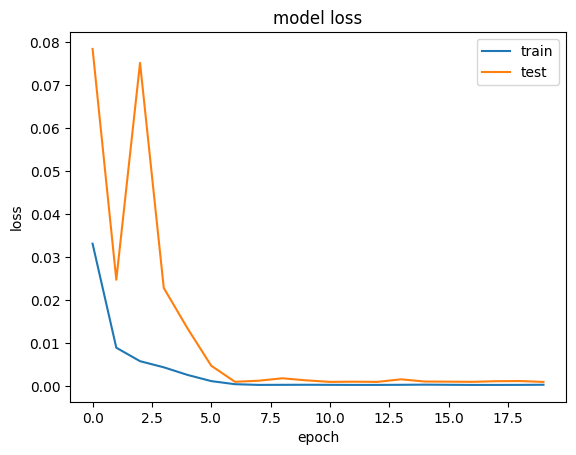

In [69]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [70]:
predictions_train = model.predict(X_train)
# Inverse transform predictions
inverse_predictions_train = inverse_transform(scaler, predictions_train)
# Inverse transform y_test
y_train_original = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]

compare_model_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_model_train.head()

,Predicted,Actual
0,23506.160506,23475.466797
1,23599.866038,22362.679688
2,23009.866807,22353.349609
3,22477.663437,22435.513672
4,22562.406213,22429.757813


In [71]:
predictions_test = model.predict(X_test)
# Inverse transform predictions
inverse_predictions_test = inverse_transform(scaler, predictions_test)
# Inverse transform y_test
y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_model_test.head()

,Predicted,Actual
0,41996.939689,42270.527344
1,42759.422566,43652.250000
2,43357.470212,43869.152344
3,44100.987748,43997.902344
4,44264.076059,43739.542969


# MATRIKS EVALUASI

In [72]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

# Menghitung R-squared
r2_xgb_train = r2_score(y_train, predictions_train)
r2_xgb_test = r2_score(y_test, predictions_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 752.897218272099
Root Mean Squared Error (RMSE) Test Set: 1336.923316605323

R-squared Train Set: 0.9742572042638069
R-squared Test Set: 0.924129743739166


# VISUALISASI

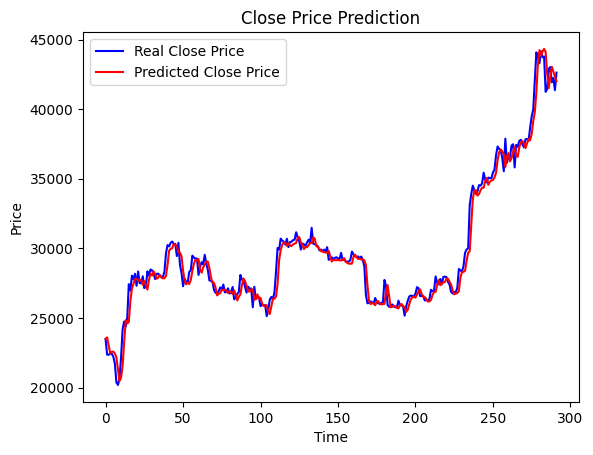

In [73]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)

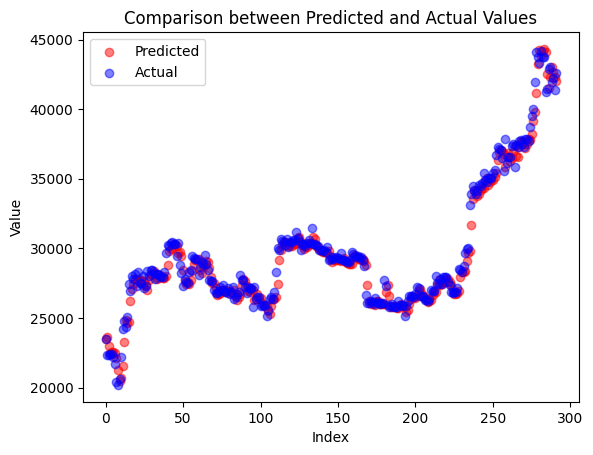

In [74]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)

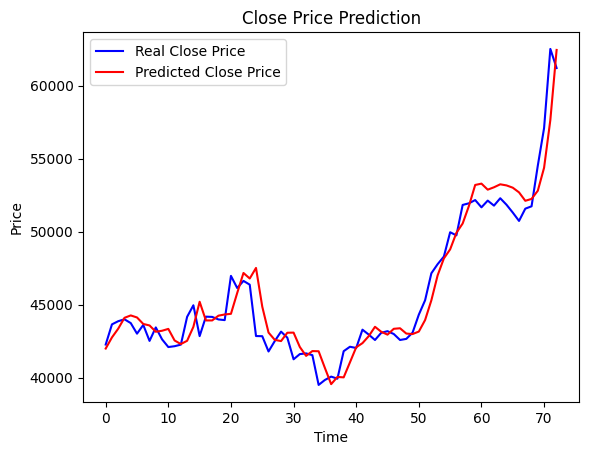

In [75]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

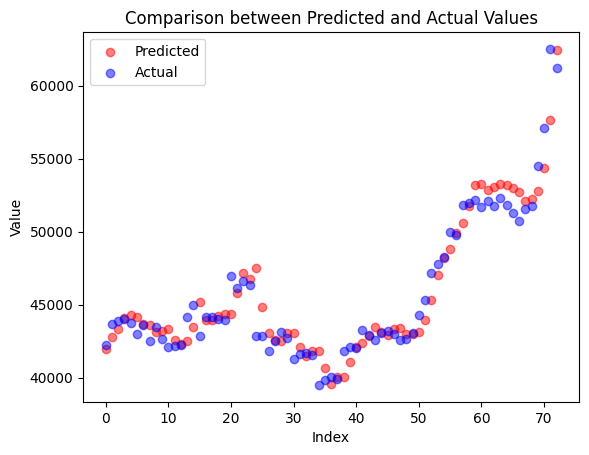

In [76]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [77]:
X_train.shape

(292, 1, 4)

In [78]:
X_test.shape

(73, 1, 4)

In [79]:
features = ["Open", "High", "Low", "Adj Close"]

# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, X_train)
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test)
# init the JS visualization code
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

# TEST DENGAN DATA BARU

In [80]:
dt = pd.read_excel('all_data_validation.xlsx')

In [81]:
dt = dt.drop(columns=['Date', 'Volume', 'Sentimen', 'Index'])

In [82]:
X_ = dt.drop(columns=['Close'])
y_ = dt['Close']

In [83]:
X, y, scalers = scale_data(dt)

In [84]:
predictions = model.predict(X)
# inverse transform predictions
inverse_predictions_new = inverse_transform(scaler, predictions)
# Inverse transform y_test
y_test_original_new = scaler.inverse_transform(np.concatenate((X[:, -1, :], y.reshape(-1, 1)), axis=1))[:, -1]

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_new, 'Actual': y_test_original_new})
compare_model_test.head()

,Predicted,Actual
0,22512.465178,20630.750967
1,23365.618603,24939.978206
2,24523.956623,44498.894232
3,36075.701227,27341.079872
4,35050.521012,36075.298051


In [85]:
mse_model_newdata = mean_squared_error(y_test_original_new, inverse_predictions_new)
rmse_model_newdata = np.sqrt(mse_model_newdata)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_newdata)
print("======================================================")

# Menghitung R-square
r2_xgb_test = r2_score(y_test_original_new, inverse_predictions_new)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Test Set: 9074.65203635893
R-squared Test Set: 0.36372608511249294


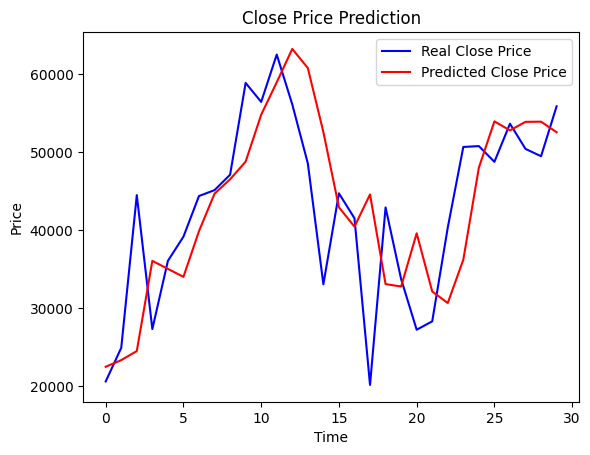

In [86]:
lineplot(y_test_original_new, inverse_predictions_new)

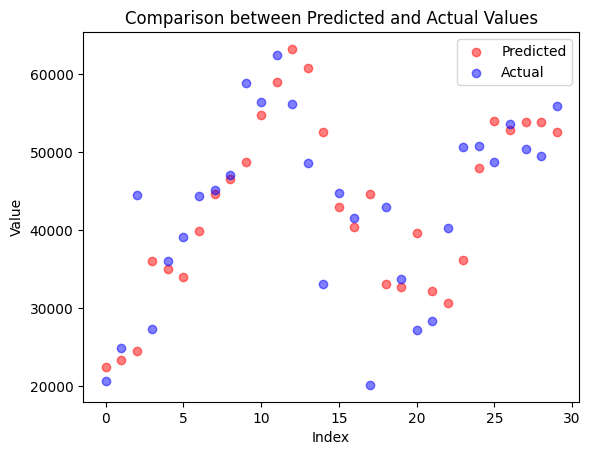

In [87]:
scatterplot(y_test_original_new, inverse_predictions_new)